In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import spacy
import nltk
import re
from tqdm import tqdm
from nltk import pos_tag_sents

# nlp = spacy.load("en_core_web_sm")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Functions

In [4]:
def clean_data(text):
  if type(text) != float:
    text = text.encode("utf-8", errors='ignore').decode("utf-8")
    text = re.sub("({.*})+", '', text)
    text = re.sub("(<.*>)+", "'", text)
    text = re.sub("[\"*]", "'", text)
    text = re.sub("[\'*]", '', text)
    return text.strip()
  else:
    return "NaN"


def remove_special_character(x):
  """
    Input:
      - x: string
    Output: string that already removed special character
  """
  if type(x) != float:
    temp = re.sub('[^A-Za-z0-9]+', ' ', x)
    return temp
  else:
    return "NaN"
def common(x, y):
  """
    Input:
      - x: set, list
      - y: set, list
    Output: set of common words of x and y
  """
  x = set(x)
  y = set(y)
  return x&y

def get_vocab(sentence, rm_character = False, split_by = " "):
  """
    Input:
      - sentence: string
      - rm_character: (True, False) Remove specical character or not. Default is False
      - split_by: split string by character. Default is " "
    Output: Vocabulary set of sentence
  """
  vocab = {""}
  sentence = str(sentence)
  if rm_character == True:
    sentence = remove_special_character(sentence)
  for word in sentence.split(split_by):
    vocab.add(word)
  return vocab

def get_weighted_vocab(sentence, rm_character = False, split_by = " "):
  """
    Input:
      - sentence: string, list, array
      - rm_character: (True, False) Remove specical character or not. Default is False
      - split_by: split string by character. Default is " "
    Output: (Dictionary) Weighted vocabulary set of sentence
  """
  vocab = {}
  if type(sentence) == str:
    if rm_character == True:
      sentence = remove_special_character(sentence)
    for word in sentence.split(split_by):
      if word not in vocab:
        vocab.update({word: 1})
      else:
        vocab[word] += 1
  else:
    if len(sentence) != 0:
      for word in sentence:
        if word not in vocab:
          vocab.update({word: 1})
        else:
          vocab[word] += 1
    else:
      return {}
  return vocab

def weighted_common(x, y):
  """
    Input:
      - x: (dictionary) weighted vocab
      - y: (dictionary) weighted vocab
    Output: set of common words of x and y (weight x + weight y)
  """
  common = {}
  len_x = len(x)
  len_y = len(y)
  if len_x < len_y:
    for key in x.keys():
      if key in y:
        common.update({key: x[key] + y[key]})
  else:
      for key in y.keys():
        if key in x:
          common.update({key: x[key] + y[key]})
  return common

def mean_weight(x):
  """
    Input:
      - x: (dictionary) weighted vocab
    Output: mean weight
  """
  if len(x.values()) == 0:
    return 0
  return sum(x.values())/len(x.values())

def get_sentence_pair(idx, pairset, nodeset):
  """
    Input:
      - idx: index of pair in pairset
      - pairset:  dataset contain pairs
      - nodeset: dataset contains nodes
    Output: pair of sentence
  """
  id1 = pairset.loc[idx]['id1']
  id2 = pairset.loc[idx]['id2']
  s1 = str(nodeset[nodeset['id'] == id1].iloc[0,1])
  s2 = str(nodeset[nodeset['id'] == id2].iloc[0,1])
  return s1, s2

def get_postag_pair(idx, pairset, nodeset):
  """
    Input:
      - idx: index of pair in pairset
      - pairset:  dataset contain pairs
      - nodeset: dataset contains nodes
    Output: pair of postag
  """
  id1 = pairset.loc[idx]['id1']
  id2 = pairset.loc[idx]['id2']
  pt1 = nodeset['embedded_postag'][id1]
  pt2 = nodeset['embedded_postag'][id2]
  return pt1, pt2

def postagging(text, type = "nltk"):
  """
    Input:
      - text: string
      - type = ("nltk", "spacy") Postagger. Default is nltk
    Output: list of postag pair (tuple)
  """
  if type == "nltk":
    tokens = nltk.word_tokenize(text)
    tag = nltk.pos_tag(tokens)
    return tag
  elif type == "spacy":
    doc = nlp(text)
    postag = [(x, x.pos_) for x in doc]
    return postag

def postag_format(x):
  """
  Input:
    - x: (string) line from saved postag csv
  Output: list of list (word, postag)
  """
  temp = x.split("(")
  temp = temp[1:len(temp)]
  postag = []
  for i in temp:
    i = i.replace('\'',"")\
              .replace(")","")\
              .replace("\"","")\
              .replace(" ","").split(',')
    i = i[0:2]
    postag.append(i)
  return postag

def embedded_format(x):
  res = re.findall(r"\[\s*\+?(-?\d+)\s*\.\]", x)
  # return remove_special_character(x).split(" ")[1:-1]
  return res

def summarize_weighted(x, y):
  """
    Input:
      - x: (dictionary) weighted vocab
      - y: (dictionary) weighted vocab
    Output: dict of total number of common words between x and y (weight x + weight y)
  """
  len_x = len(x)
  len_y = len(y)
  if len_x > len_y:
    for key in x.keys():
      if key in y:
        x[key] = x[key] + y[key]
    return x
  else:
    for key in y.keys():
      if key in x:
        y[key] = y[key] + x[key]
    return y

def postag_embedding(sentence, list_postag):
  """
  Input:
    - sentence: (string) sentence that needs to be embedded
    - list_postag: (1D iteration) POSTAG to embed
  Output: Embedding vector
  """

  embedding = np.zeros((len(list_postag),1))

  pt = postagging(remove_special_character(sentence), type = "nltk")
  try:
    pt = get_weighted_vocab(np.array(pt).T[1], True)
  except:
    pt = {}

  # print(pt)

  for i, postag in enumerate(list_postag):
    if postag in list(pt.keys()):
      embedding[i] = pt[postag]
  return embedding

def name_postag(x, number):
  return [i + number for i in x]

In [ ]:
remove_special_character("the_king_om_of_ruin")

'king om ruin'

# Import datasets

In [5]:
train = pd.read_csv("/content/drive/MyDrive/Code/DSAA/data/train.csv").drop(['id'], axis=1)
train

,id1,id2,label
0,9202,9202,1
1,410411,460254,0
2,211858,312074,1
3,253901,504325,0
4,415071,63239,0
...,...,...,...
948227,177447,82731,1
948228,141580,396615,0
948229,817680,271396,0
948230,756771,322480,0


In [14]:
train['label'].value_counts()

0    512389
1    435843
Name: label, dtype: int64

<Axes: >

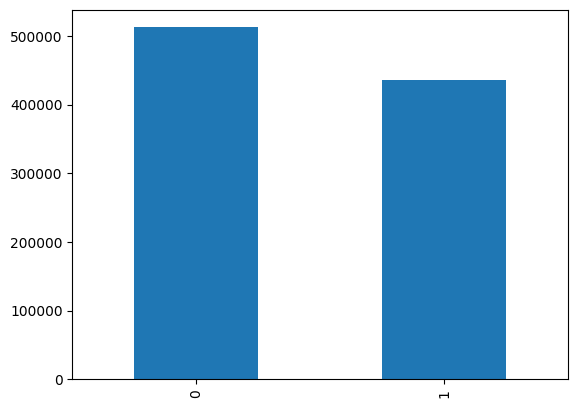

In [13]:
train['label'].value_counts().plot(kind = "bar")

Get 1-label indexes

In [17]:
index_label = train.index[train['label'] == 1].tolist()

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/Code/DSAA/data/test.csv").drop(['id'], axis=1)
test

,id1,id2
0,253077,253077
1,235274,65408
2,172772,677546
3,378856,175720
4,825250,35839
...,...,...
238359,187029,655064
238360,551893,705610
238361,60182,259001
238362,403303,391419


In [ ]:
nodes = pd.read_csv("/content/drive/MyDrive/Code/DSAA/data/nodes/nodes.tsv", sep = "\t", index_col=None)
nodes

,id,text
0,1,{{infobox person | name = clayton jacobson | i...
1,2,a '''cobra probe''' is a device to measure the...
2,3,the '''harmon foundation''' was established in...
3,4,'''structured finance''' is a sector of financ...
4,5,'''al-shohada'a stadium''' is a multi-use stad...
...,...,...
837829,836621,{{infobox publisher | name = houghton mifflin ...
837830,836622,{{infobox former subdivision |native_name = }}...
837831,836623,"'''janjira''' may refer to: * janjira state, a..."
837832,344599,'''serendip''' ('''search for extraterrestrial...


In [ ]:
node_ids = nodes['id']

# Find insights

## Length

### Get texts' length

In [ ]:
text_length_word_r = [len(remove_special_character(str(x)).split(' ')) for x in nodes['text']]

Get whole dataset's vocabulary (remove special character + split by space)

In [ ]:
vocab_word_r = {""}
for text in nodes['text']:
  for word in remove_special_character(str(text)).split(' '):
    vocab_word_r.add(word)

print("Vocabulary's length (word + remove spec character): {}".format(len(vocab_word_r)))

Vocabulary's length (word + remove spec character): 1465941


Plot the distribution of texts' length

<ipython-input-73-9b87e6b50f2d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(text_length).set(title="Distribution of texts' length by word (without special characters)")


[Text(0.5, 1.0, "Distribution of texts' length by word (without special characters)")]

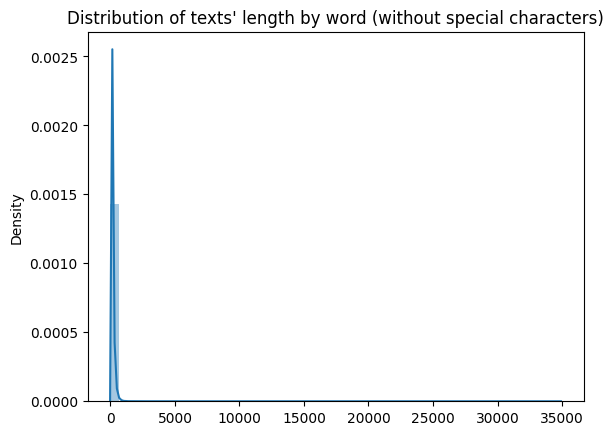

In [ ]:
sns.distplot(text_length_word_r).set(title="Distribution of texts' length by word (without special characters)")

Basic insights

In [ ]:
pd.DataFrame(text_length_word_r).describe()

,0
count,837834.000000
mean,115.782661
std,153.560819
min,1.000000
25%,47.000000
50%,79.000000
75%,144.000000
max,34889.000000


### Common words between a pair of node

In [ ]:
list_common = []
for idx in tqdm(range(len(train))):
  sen1, sen2 = get_sentence_pair(idx, train, nodes)

  t1 = get_vocab(sen1, rm_character = True)
  t2 = get_vocab(sen2, rm_character = True)
  common_words = common(t1, t2)
  list_common.append([len(sen1), len(sen2), len(common_words), common_words])

In [ ]:
pd_common = pd.DataFrame(list_common)
pd_common.columns = ["sen1_len", "sen2_len", "common_len", "common_words"]
pd_common

,sen1_len,sen2_len,common_len,common_words
0,348,348,24,"{, map, an, pskov, the, municipal, russia, is,..."
1,271,202,6,"{, of, it, is, in, the}"
2,480,52,7,"{, of, is, a, in, korea, the}"
3,1218,1628,16,"{, name, s, of, to, and, infobox, southern, by..."
4,3,872,1,{}
...,...,...,...,...
948227,175,1116,8,"{, of, is, in, a, the, lindsey, kirton}"
948228,1436,1771,78,"{, espncricinfo, born, clubnumber1, score2, ba..."
948229,1015,148,3,"{, of, the}"
948230,86,81,1,{}


In [ ]:
#Save
pd_common.to_csv("/content/drive/MyDrive/Code/DSAA/common.csv")

In [15]:
#Load
pd_common = pd.read_csv("/content/drive/MyDrive/Code/DSAA/common.csv")

<ipython-input-18-d3d5a5ded0a0>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pd_common.loc[index_label]['common_len']).set(title = "Distribution of common words' length between a pair of node")


[Text(0.5, 1.0, "Distribution of common words' length between a pair of node")]

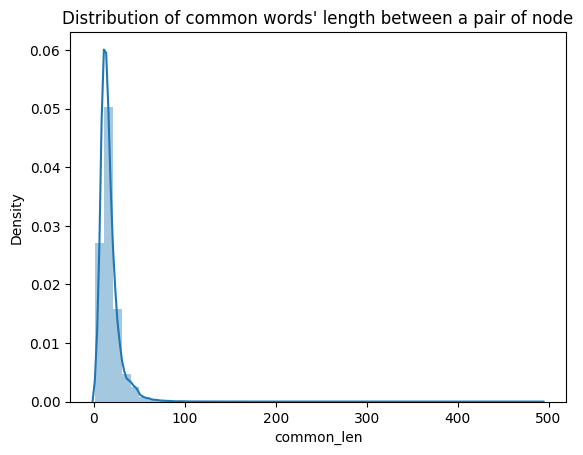

In [18]:
sns.distplot(pd_common.loc[index_label]['common_len']).set(title = "Distribution of common words' length between a pair of node")

Basic insight

In [19]:
pd_common.loc[index_label]['common_len'].describe()

count    435843.000000
mean         16.801713
std          10.929580
min           1.000000
25%          10.000000
50%          14.000000
75%          20.000000
max         492.000000
Name: common_len, dtype: float64

### Weighted common words between a pair of node

In [ ]:
list_weighted_common = []
for idx in tqdm(range(len(train))):
  sen1, sen2 = get_sentence_pair(idx, train, nodes)

  t1 = get_weighted_vocab(sen1, True)
  t2 = get_weighted_vocab(sen2, True)

  common_weighted = weighted_common(t1, t2)
  list_weighted_common.append(common_weighted)

100%|██████████| 948232/948232 [52:41<00:00, 299.95it/s]


In [ ]:
import json
with open('/content/drive/MyDrive/Code/DSAA/weighted_common.json', 'w') as fout:
    json.dump(list_weighted_common, fout)

Calculate mean of weight

In [ ]:
list_mean_weight = []
for vocab in list_weighted_common:
  list_mean_weight.append(mean_weight(vocab))

In [ ]:
pd.DataFrame(list_mean_weight).loc[index_label]

,0
0,4.260870
2,2.571429
8,10.529412
13,6.000000
14,5.000000
...,...
948220,3.055556
948221,3.692308
948222,5.823529
948225,6.000000


<ipython-input-109-e0ce3ae2458c>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pd.DataFrame(list_mean_weight).loc[index_label]).set(title = "Distribution of mean weight from common words between a pair of node")


[Text(0.5, 1.0, 'Distribution of mean weight from common words between a pair of node')]

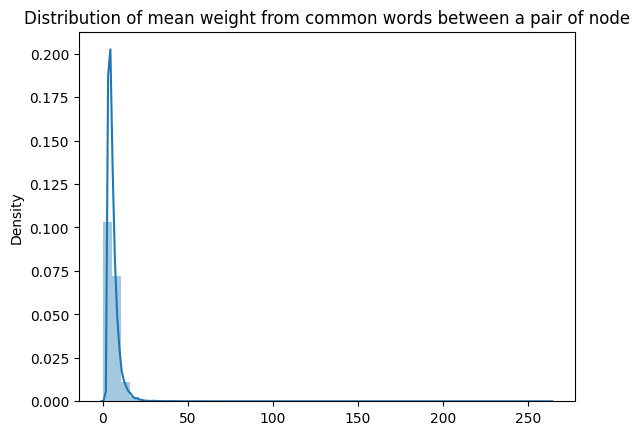

In [ ]:
sns.distplot(pd.DataFrame(list_mean_weight).loc[index_label]).set(title = "Distribution of mean weight from common words between a pair of node")

Basic insight

In [ ]:
pd.DataFrame(list_mean_weight).loc[index_label].describe()

,0
count,435843.000000
mean,5.940068
std,3.593831
min,0.000000
25%,3.800000
50%,5.000000
75%,7.000000
max,263.333333


## POS_TAG

Make weighted common postag without a pre-postagging </br>
Could crash the session

### Calculate number of common postag' appearance (weighted) of a pair of node in trainset

In [ ]:
list_weighted_common_pos = []
for idx in tqdm(range(len(train))):
  sen1, sen2 = get_sentence_pair(idx, train, nodes)
  p1 = postagging(clean_data(sen1), type = "nltk")
  p2 = postagging(clean_data(sen2), type = "nltk")
  try:
    t1 = get_weighted_vocab(np.array(p1).T[1], True)
    t2 = get_weighted_vocab(np.array(p2).T[1], True)
  except:
    t1 = {}
    t2 = {}
  common_weighted = weighted_common(t1, t2)
  list_weighted_common_pos.append(common_weighted)

 29%|██▉       | 277906/948232 [1:14:23<3:54:40, 47.61it/s]

In [ ]:
del nodes

In [ ]:
# Save
import json
with open('/content/drive/MyDrive/Code/DSAA/weighted_common_pos_Tam.json', 'w') as fout:
    json.dump(list_weighted_common_pos, fout)

In [ ]:
# Load
import json

# f = open('/content/drive/MyDrive/Code/DSAA/clean_weighted_common_pos.json')
f = open('/content/drive/MyDrive/Code/DSAA/weighted_common_pos.json')
list_weighted_common_pos = json.load(f)

In [ ]:
len(list_weighted_common_pos)

948232

In [ ]:
list_weighted_common_pos[0]

{'NN': 46,
 'IN': 12,
 ':': 6,
 '(': 4,
 'JJ': 20,
 ')': 4,
 'FW': 4,
 'VBZ': 2,
 'DT': 6,
 'CC': 2,
 'NNS': 2,
 ',': 8}

### Number of common postag's appearance (not weighted) for the whole trainset

In [ ]:
list_contain_postag_label1 = []
for i in tqdm(range(len(list_weighted_common_pos))):
  if train['label'][i] == 1:
    list_contain_postag_label1 += list(list_weighted_common_pos[i].keys())

100%|██████████| 948232/948232 [00:07<00:00, 127467.08it/s]


In [ ]:
postag = list(set(list_contain_postag_label1))

In [ ]:
summarize_postag = [[postag[i], list_contain_postag_label1.count(postag[i])] for i in range(len(postag))]
summarize_postag = pd.DataFrame(summarize_postag)
summarize_postag.columns = ["postag", "count"]
summarize_postag.sort_values('count', inplace = True)

[Text(0.5, 1.0, "Number of common postag's appearance (not weighted) for the whole trainset")]

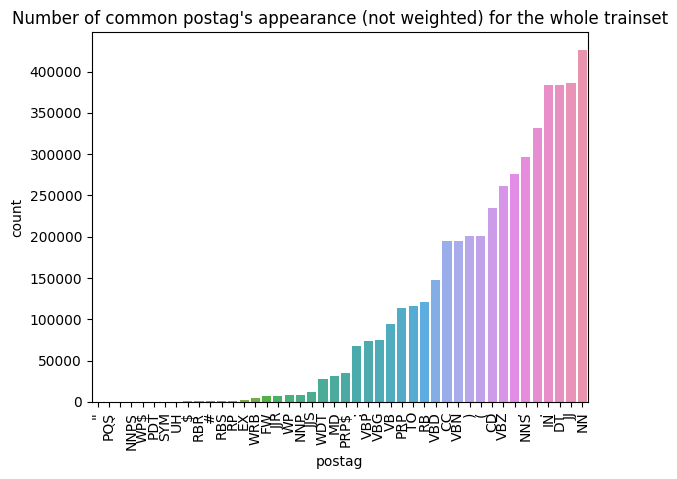

In [ ]:
plot = sns.barplot(data = summarize_postag, x = 'postag', y= "count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.set(title = "Number of common postag's appearance (not weighted) for the whole trainset")

#### ------- Label 0

In [ ]:
list_contain_postag_label0 = []
for i in tqdm(range(len(list_weighted_common_pos))):
  if train['label'][i] == 0:
    list_contain_postag_label0 += list(list_weighted_common_pos[i].keys())

100%|██████████| 948232/948232 [00:08<00:00, 118113.39it/s]


[Text(0.5, 1.0, "Number of common postag's appearance (not weighted) for the whole trainset (Label 0)")]

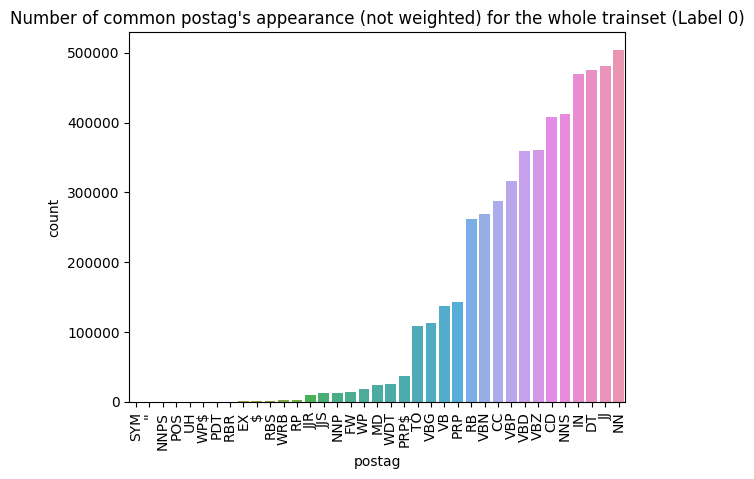

In [ ]:
summarize_postag_0 = [[postag[i], list_contain_postag_label0.count(postag[i])] for i in range(len(postag))]
summarize_postag_0 = pd.DataFrame(summarize_postag_0)
summarize_postag_0.columns = ["postag", "count"]
summarize_postag_0.sort_values('count', inplace = True)

plot = sns.barplot(data = summarize_postag_0, x = 'postag', y= "count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.set(title = "Number of common postag's appearance (not weighted) for the whole trainset (Label 0)")

### Number of common postag's appearance (weighted) for the whole trainset

In [ ]:
postag = list(set(list_contain_postag_label1))

In [ ]:
dict_contain_weighted_postag_label1 = list_weighted_common_pos[0]
for i in tqdm(range(1, len(list_weighted_common_pos))):
  if train['label'][i] == 1:
    dict_contain_weighted_postag_label1 = summarize_weighted(\
                                            dict_contain_weighted_postag_label1,\
                                            list_weighted_common_pos[i])

100%|██████████| 948231/948231 [00:10<00:00, 88684.18it/s] 


In [ ]:
summarize_postag_weighted = pd.DataFrame(list(dict_contain_weighted_postag_label1.items()))
summarize_postag_weighted.columns = ["postag", "count"]
summarize_postag_weighted.sort_values('count', inplace = True)
summarize_postag_weighted

,postag,count
14,EX,524
15,RBR,860
23,PDT,1417
16,JJR,4462
25,RBS,5096
17,JJS,8509
21,MD,17626
22,WRB,18571
26,WP,23926
8,WDT,104026


[Text(0.5, 1.0, "Number of common postag's appearance (weighted) for the whole trainset")]

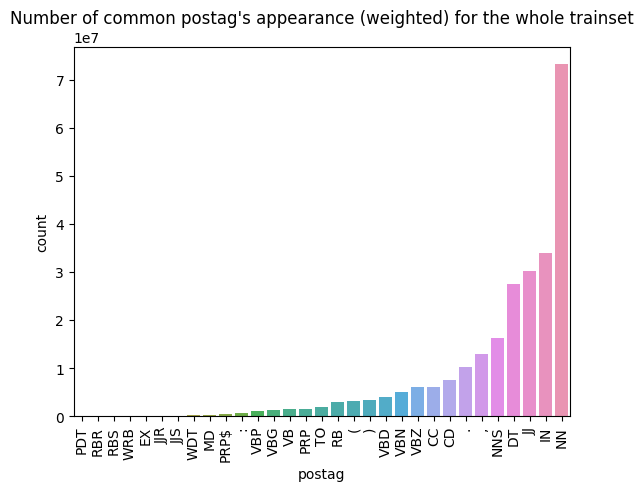

In [ ]:
plot = sns.barplot(data = summarize_postag_weighted, x = 'postag', y= "count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.set(title = "Number of common postag's appearance (weighted) for the whole trainset")

#### -------- Label 0

In [ ]:
dict_contain_weighted_postag_label0 = list_weighted_common_pos[0]
for i in tqdm(range(1, len(list_weighted_common_pos))):
  if train['label'][i] == 0:
    dict_contain_weighted_postag_label0 = summarize_weighted(\
                                            dict_contain_weighted_postag_label0,\
                                            list_weighted_common_pos[i])

100%|██████████| 948231/948231 [00:07<00:00, 132983.08it/s]


[Text(0.5, 1.0, "Number of common postag's appearance (weighted) for the whole trainset (label 0)")]

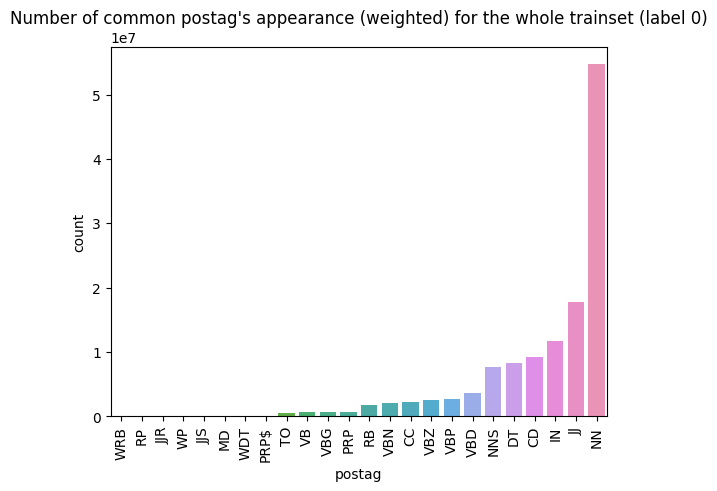

In [ ]:
summarize_postag_weighted_0 = pd.DataFrame(list(dict_contain_weighted_postag_label0.items()))
summarize_postag_weighted_0.columns = ["postag", "count"]
summarize_postag_weighted_0.sort_values('count', inplace = True)

plot = sns.barplot(data = summarize_postag_weighted_0, x = 'postag', y= "count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.set(title = "Number of common postag's appearance (weighted) for the whole trainset (label 0)")

### Summarize

In [ ]:
summarize_postag.sort_values("postag", inplace = True)
summarize_postag.columns = ["postag", "count_1"]

summarize_postag_0.sort_values("postag", inplace = True)
summarize_postag_0.columns = ["postag", "count_0"]

summarize_postag_weighted.sort_values("postag", inplace = True)
summarize_postag_weighted.columns = ["postag", "count_1_weighted"]

summarize_postag_weighted_0.sort_values("postag", inplace = True)
summarize_postag_weighted_0.columns = ["postag", "count_0_weighted"]

In [ ]:
summarize = summarize_postag.merge(summarize_postag_0, how = "inner", on = "postag")
summarize = summarize.merge(summarize_postag_weighted, how = "inner", on = "postag")
summarize = summarize.merge(summarize_postag_weighted_0, how = "inner", on = "postag")

In [ ]:
summarize

,postag,count_1,count_0,count_1_weighted,count_0_weighted
0,CC,228715,288039,2327962,2170937
1,CD,319293,408570,9261089,9213107
2,DT,408049,474811,10174090,8269955
3,IN,412859,469299,14400212,11707646
4,JJ,421892,480844,19947787,17822116
5,JJR,13346,9434,4462,25319
6,JJS,19713,12261,8509,43791
7,MD,42531,24836,17626,65422
8,NN,435092,504043,54274997,54672403
9,NNS,368000,411579,8703753,7699174


In [ ]:
summarize.to_excel("/content/drive/MyDrive/Code/DSAA/analyze/summarize_old_tagging.xlsx", index = False)

### Create tokenized list for faster pos-tagging </br>
Preventing crashing
</br> Failed (retrieval time takes too long)

**First tokenize sentences**

In [ ]:
tokenized_list = []
for i in tqdm(range(len(nodes['text']))):
  tokenized = nltk.word_tokenize(remove_special_character(str(nodes['text'][i])))
  tokenized_list.append(tokenized)

100%|██████████| 837834/837834 [08:35<00:00, 1623.79it/s]


In [ ]:
#Save
import csv

with open("/content/drive/MyDrive/Code/DSAA/tokenized.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(tokenized_list)

In [ ]:
#Load
file1 = open("/content/drive/MyDrive/Code/DSAA/tokenized.csv", 'r')
lines = file1.readlines()

tokenized_list = []
for line in lines:
  tokenized_list.append(line.replace('\n',"").split(','))
del file1
del lines

**pos-tagging entire nodeset** </br>
split into 2 half because the free colab's memory couldn't handle the whole thing

In [ ]:
half = len(tokenized_list)//2
half

418917

In [ ]:
list_pos = pos_tag_sents(tokenized_list[418917:len(tokenized_list)])
del tokenized_list

In [ ]:
#Save
import csv

with open("/content/drive/MyDrive/Code/DSAA/postag_2.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(list_pos)

In [ ]:
#Load
file1 = open("/content/drive/MyDrive/Code/DSAA/postag_1.csv", 'r')
lines = file1.readlines()

list_pos = []
for line in lines:
  list_pos.append(postag_format(line))
del file1
del lines

In [ ]:
file1 = open("/content/drive/MyDrive/Code/DSAA/postag_2.csv", 'r')
lines = file1.readlines()

In [ ]:
#Save to txt file

for i in tqdm(range(418917, len(nodes))):
  with open("/content/drive/MyDrive/Code/DSAA/data/pos_tag/{}.txt".format(node_ids[i]), "w") as f:
      pt = postag_format(lines[i - 418917])
      for part in pt:
          f.write("{},{}".format(part[0], part[1]))
          f.write("\n")

# del file1
# del lines

100%|██████████| 418917/418917 [59:24<00:00, 117.53it/s]


In [ ]:
file1 = open("/content/drive/MyDrive/Code/DSAA/data/pos_tag/1.txt", 'r')
lines = file1.readlines()

# Embedding by POSTAGGING
No need now, coz we can make embedded nodeset

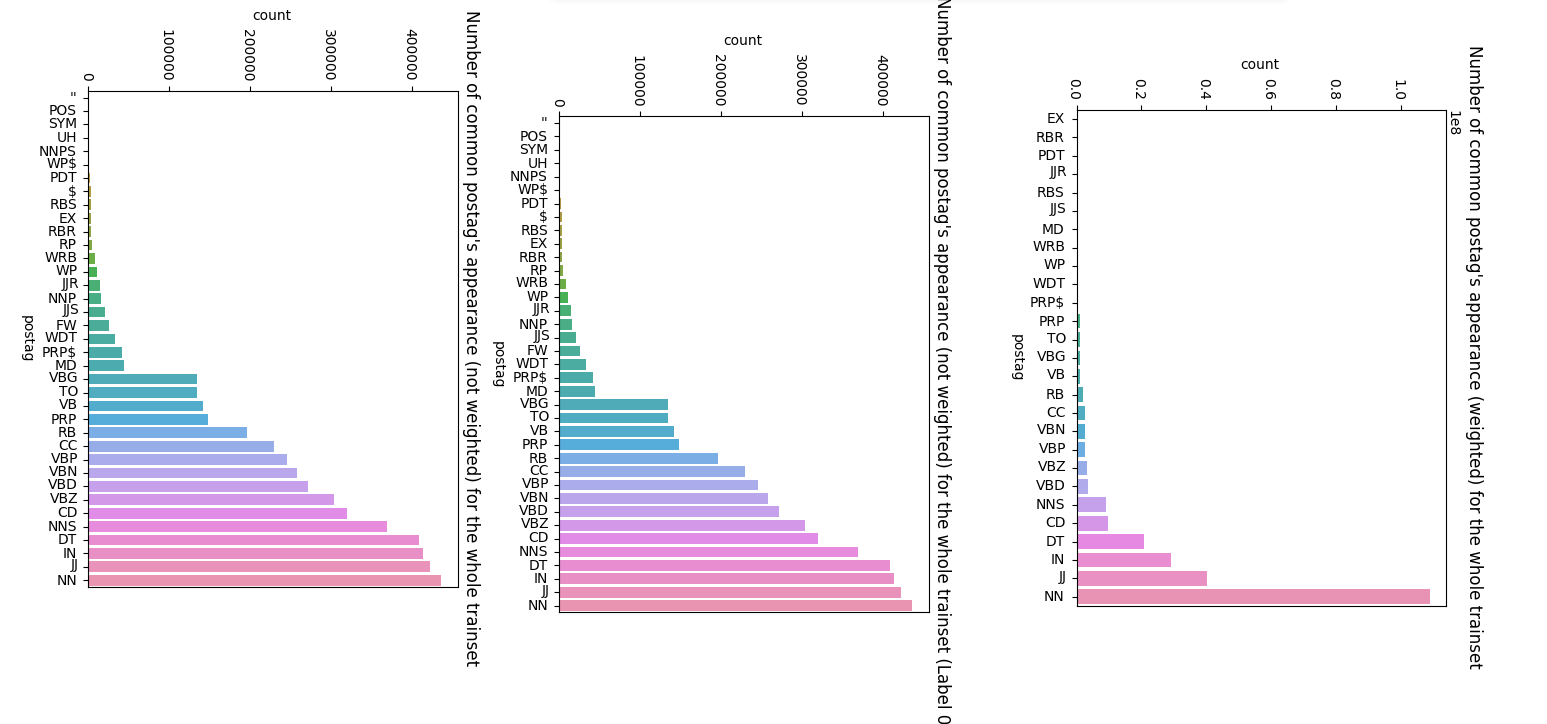

In [ ]:
# embed_postag = ["NN", "JJ", "IN", "DT", "NNS","CD","VBD","VBZ","VBP","VBN"]
embed_postag = ["NN", "JJ", "IN", "DT", "NNS","CD","VBZ"]
sentence = nodes['text'][5]

postag_embedding(sentence, embed_postag)

array([[7.],
       [3.],
       [1.],
       [2.],
       [0.],
       [1.],
       [1.]])

In [ ]:
embedded_nodes = []
for i in tqdm(range(len(nodes))):
  embedded_nodes.append([nodes['id'][i], postag_embedding(str(nodes['text'][i]), embed_postag)])

100%|██████████| 837834/837834 [53:03<00:00, 263.19it/s]


In [ ]:
embedded_df = pd.DataFrame(embedded_nodes)
embedded_df.columns = ["id","embedded_postag"]

In [ ]:
# Save
embedded_df.to_csv("/content/drive/MyDrive/Code/DSAA/data/embedded/clean_nodes_embedded_nltk_7_vbz.csv")

In [ ]:
# Load
embedded_df = pd.read_csv("/content/drive/MyDrive/Code/DSAA/data/embedded/clean_nodes_embedded_nltk_7_vbz.csv")
embedded_df['embedded_postag'] = embedded_df['embedded_postag'].apply(embedded_format)
embedded_df

,Unnamed: 0,id,embedded_postag
0,0,1,"[27, 7, 8, 6, 3, 5, 4]"
1,1,2,"[37, 23, 22, 26, 11, 5, 7]"
2,2,3,"[60, 32, 40, 24, 25, 10, 2]"
3,3,4,"[32, 12, 11, 6, 10, 1, 3]"
4,4,5,"[11, 2, 4, 3, 4, 1, 3]"
...,...,...,...
837829,837829,836621,"[12, 3, 3, 3, 7, 0, 2]"
837830,837830,836622,"[76, 48, 54, 46, 28, 14, 0]"
837831,837831,836623,"[23, 14, 8, 9, 0, 2, 0]"
837832,837832,344599,"[27, 8, 11, 5, 6, 0, 3]"


In [ ]:
# Try to get a pair of embedded postag in trainset
id = 3
p1, p2 = get_postag_pair(id, train, embedded_df)
p1 + p2

['35', '11', '16', '9', '4', '7', '2', '11', '2', '4', '3', '1', '2', '1']

#  Make embedded nodeset

In [ ]:
postag = list(set(list_contain_postag_label1))

In [ ]:
node_embedding = np.zeros((len(nodes), 1 + len(postag)))

In [ ]:
node_embedding.shape

(837834, 38)

In [ ]:
for i in tqdm(range(len(nodes))):
  node_embedding[i][0] = nodes['id'][i]
  node_embedding[i][1:45] = postag_embedding(nodes['text'][i], postag).reshape(node_embedding.shape[1] - 1 ,)

100%|██████████| 837834/837834 [1:54:03<00:00, 122.42it/s]


In [ ]:
df_node_embedding = pd.DataFrame(node_embedding)
df_node_embedding.columns = ["id"] + postag
df_node_embedding

,id,$,VBD,UH,NNS,JJS,NNP,'',PDT,IN,...,PRP$,RB,WP$,CD,DT,TO,MD,PRP,WRB,WP
0,1.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,7.0,...,1.0,3.0,0.0,6.0,6.0,1.0,0.0,2.0,0.0,0.0
1,2.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,23.0,...,0.0,4.0,0.0,13.0,26.0,2.0,0.0,3.0,1.0,0.0
2,3.0,0.0,16.0,0.0,24.0,1.0,0.0,0.0,0.0,40.0,...,3.0,4.0,0.0,12.0,24.0,4.0,1.0,2.0,0.0,1.0
3,4.0,0.0,1.0,0.0,15.0,0.0,0.0,0.0,0.0,13.0,...,1.0,6.0,0.0,1.0,6.0,3.0,1.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,...,0.0,3.0,0.0,2.0,4.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837829,836621.0,0.0,4.0,0.0,19.0,0.0,1.0,0.0,0.0,5.0,...,0.0,0.0,0.0,8.0,3.0,0.0,0.0,2.0,0.0,0.0
837830,836622.0,0.0,20.0,0.0,28.0,0.0,0.0,0.0,0.0,68.0,...,5.0,11.0,0.0,27.0,55.0,5.0,2.0,1.0,2.0,0.0
837831,836623.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,...,0.0,2.0,0.0,3.0,9.0,1.0,1.0,0.0,0.0,0.0
837832,344599.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,11.0,...,1.0,1.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_node_embedding.to_csv("/content/drive/MyDrive/Code/DSAA/data/nodes/node_embedding_Tam.csv", index = False)

In [ ]:
df_node_embedding = pd.read_csv("/content/drive/MyDrive/Code/DSAA/data/nodes/node_embedding.csv")
df_node_embedding['id'] = df_node_embedding['id'].astype(int)

In [ ]:
df_node_embedding

,id,.,(,NNPS,WDT,VBP,RBS,NNS,JJR,VBG,...,MD,PRP$,CC,SYM,WRB,NNP,VBZ,'',VBN,CD
0,1,6.0,3.0,0.0,0.0,1.0,0.0,3.0,0.0,2.0,...,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,3.0,5.0
1,2,8.0,0.0,0.0,2.0,3.0,0.0,11.0,0.0,1.0,...,0.0,0.0,5.0,0.0,1.0,0.0,7.0,0.0,5.0,5.0
2,3,10.0,2.0,0.0,1.0,1.0,0.0,25.0,0.0,4.0,...,1.0,3.0,9.0,0.0,0.0,0.0,2.0,0.0,11.0,10.0
3,4,4.0,1.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,...,1.0,1.0,6.0,0.0,0.0,2.0,3.0,0.0,4.0,1.0
4,5,3.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837829,836621,2.0,1.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
837830,836622,12.0,7.0,0.0,1.0,0.0,0.0,28.0,1.0,7.0,...,1.0,5.0,10.0,0.0,2.0,0.0,0.0,0.0,10.0,14.0
837831,836623,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
837832,344599,3.0,2.0,0.0,0.0,2.0,0.0,6.0,0.0,3.0,...,0.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0


# Make embedded training set

In [ ]:
nametrain = "trainset_embedded_nltk_full"
nametest = "testset_embedded_nltk_full"

In [ ]:
# embed_postag = ["NN", "IN", "JJ", "DT", "NNS",",",".","CD","CC","VBZ","VBN","VBD"]
embed_postag = list(df_node_embedding.columns)
embed_postag.remove("id")
# embed_postag = ["CC","CD","DT","IN","JJ","JJR","JJS","MD","NN","NNS","PRP","PRP$","RB","TO","VB","VBD","VBG","VBN"]
# embed_postag = postag
embedded_nodeset = df_node_embedding[embed_postag]

In [ ]:
len(embed_postag)

37

In [ ]:
train_embedded_test = []

for i in tqdm(range(len(train))):
  idx1 = train['id1'][i]
  idx2 = train['id2'][i]
  train_embedded_test.append(list(embedded_nodeset.loc[idx1]) + list(embedded_nodeset.loc[idx2]))

100%|██████████| 948232/948232 [02:29<00:00, 6323.88it/s]


In [ ]:
# train_embedded = []
# for i in tqdm(range(len(train))):
#   p1, p2 = get_postag_pair(i, train, embedded_df)
#   train_embedded.append(p1+p2)

In [ ]:
train_df = pd.DataFrame(train_embedded_test)
# train_df.drop([10,11,12,13,14,15,16,17,18,19], axis = 1, inplace = True)
train_df.columns = name_postag(embed_postag, "1") + name_postag(embed_postag, "2")
train_df = pd.concat([train_df, pd.DataFrame(train['label'])], axis =1).fillna(0)
train_df

,$1,VBD1,UH1,NNS1,JJS1,NNP1,''1,PDT1,IN1,JJR1,...,RB2,WP$2,CD2,DT2,TO2,MD2,PRP2,WRB2,WP2,label
0,0.0,2.0,0.0,8.0,0.0,0.0,0.0,0.0,6.0,0.0,...,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,...,1.0,0.0,41.0,4.0,0.0,0.0,1.0,0.0,0.0,0
2,0.0,4.0,0.0,30.0,2.0,0.0,0.0,0.0,49.0,0.0,...,1.0,0.0,6.0,2.0,1.0,0.0,1.0,0.0,0.0,1
3,0.0,13.0,0.0,25.0,0.0,2.0,0.0,0.0,30.0,1.0,...,0.0,0.0,2.0,3.0,1.0,0.0,1.0,0.0,0.0,0
4,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,...,2.0,0.0,7.0,7.0,0.0,0.0,2.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948227,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,6.0,0.0,...,2.0,0.0,6.0,5.0,0.0,0.0,2.0,1.0,1.0,1
948228,0.0,6.0,0.0,21.0,0.0,0.0,0.0,0.0,28.0,0.0,...,3.0,0.0,5.0,6.0,2.0,0.0,2.0,0.0,0.0,0
948229,0.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,5.0,6.0,0.0,0.0,3.0,0.0,0.0,0
948230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,2.0,0.0,5.0,4.0,0.0,0.0,1.0,0.0,0.0,0


In [ ]:
# Save
train_df.to_csv("/content/drive/MyDrive/Code/DSAA/data/embedded/{}.csv".format(nametrain))

# Make testset embedded

In [ ]:
test_embedded_test = []

for i in tqdm(range(len(test))):
  idx1 = test['id1'][i]
  idx2 = test['id2'][i]
  test_embedded_test.append(list(embedded_nodeset.loc[idx1]) + list(embedded_nodeset.loc[idx2]))

100%|██████████| 238364/238364 [00:37<00:00, 6344.41it/s]


In [ ]:
test_df = pd.DataFrame(test_embedded_test).fillna(0)
test_df.columns = name_postag(embed_postag, "1") + name_postag(embed_postag, "2")
test_df

,$1,VBD1,UH1,NNS1,JJS1,NNP1,''1,PDT1,IN1,JJR1,...,PRP$2,RB2,WP$2,CD2,DT2,TO2,MD2,PRP2,WRB2,WP2
0,0.0,3.0,0.0,9.0,1.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,8.0,4.0,0.0,0.0,1.0,0.0,0.0
1,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,...,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
2,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,0.0,12.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,3.0,0.0,13.0,6.0,1.0,1.0,1.0,0.0,0.0
4,0.0,4.0,0.0,8.0,0.0,0.0,0.0,0.0,20.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238359,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,3.0,0.0,4.0,10.0,2.0,0.0,2.0,1.0,0.0
238360,0.0,2.0,0.0,25.0,0.0,0.0,0.0,0.0,46.0,1.0,...,0.0,0.0,0.0,14.0,4.0,1.0,0.0,1.0,0.0,0.0
238361,0.0,0.0,0.0,6.0,4.0,0.0,0.0,0.0,9.0,1.0,...,0.0,3.0,0.0,8.0,25.0,11.0,0.0,5.0,3.0,0.0
238362,0.0,2.0,0.0,19.0,0.0,0.0,0.0,0.0,8.0,0.0,...,0.0,2.0,0.0,2.0,6.0,0.0,1.0,3.0,0.0,0.0


In [ ]:
test_df.to_csv("/content/drive/MyDrive/Code/DSAA/data/embedded/{}.csv".format(nametest), index = False)